In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os  
import torch
from torch.nn.utils.rnn import pad_sequence  
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # For a nice progress bar!
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import math

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [43]:
X_train = pd.read_csv("D://ĐATN//Data//File_da_xu_ly//full_data//Data_chia_theo_CI//data_lon_hon_50//Train_Val_Test_Full//X_full_train.csv", header=0)
Y_train = pd.read_csv("D://ĐATN//Data//File_da_xu_ly//full_data//Data_chia_theo_CI//data_lon_hon_50//Train_Val_Test_Full//Y_full_train.csv", header=0)

X_val = pd.read_csv("D://ĐATN//Data//File_da_xu_ly//full_data//Data_chia_theo_CI//data_lon_hon_50//Train_Val_Test_Full//X_full_val.csv", header=0)
Y_val = pd.read_csv("D://ĐATN//Data//File_da_xu_ly//full_data//Data_chia_theo_CI//data_lon_hon_50//Train_Val_Test_Full//Y_full_val.csv", header=0)

X_test = pd.read_csv("D://ĐATN//Data//File_da_xu_ly//full_data//Data_chia_theo_CI//data_lon_hon_50//Train_Val_Test_Full//X_full_test.csv", header=0)
Y_test = pd.read_csv("D://ĐATN//Data//File_da_xu_ly//full_data//Data_chia_theo_CI//data_lon_hon_50//Train_Val_Test_Full//Y_full_test.csv", header=0)

In [44]:
X_train

,DATE (MM/DD/YYYY),Zenith Angle [degrees],Airmass,Tower Dry Bulb Temp [deg C],Tower RH [%],Opaque Cloud Cover [%],Avg Wind Direction @ 19ft [deg from N],Global Extraterrestrial (calc) [W/m^2],GHI Mean,HOUR_0,...,MONTH_9,MONTH_10,MONTH_11,MONTH_12,smooth,fluctuate,mix,sunny,heavy cloud,light cloud
0,2013-01-01 09:00:00,75.707014,3.992206,-8.1180,70.158,27.4,297.280,349.0508,102.267625,0.0,...,0.0,0.0,0.0,0.0,1,0,0,0,1,0
1,2013-01-01 09:05:00,75.062738,3.828622,-7.9614,70.540,28.0,302.440,364.4346,109.563788,0.0,...,0.0,0.0,0.0,0.0,1,0,0,0,1,0
2,2013-01-01 09:10:00,74.430628,3.680896,-7.8528,70.150,29.2,288.100,379.4834,117.345335,0.0,...,0.0,0.0,0.0,0.0,1,0,0,0,1,0
3,2013-01-01 09:15:00,73.811036,3.547010,-7.8012,72.316,31.6,168.860,394.1894,125.315798,0.0,...,0.0,0.0,0.0,0.0,1,0,0,0,1,0
4,2013-01-01 09:20:00,73.204328,3.425268,-7.8638,74.144,30.8,58.438,408.5444,133.441573,0.0,...,0.0,0.0,0.0,0.0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330715,2021-12-31 12:35:00,63.226348,2.211736,0.3022,49.298,96.4,133.520,636.8092,185.802750,0.0,...,0.0,0.0,0.0,1.0,0,0,1,0,1,0
330716,2021-12-31 12:40:00,63.378886,2.223368,0.4662,48.290,95.2,112.500,633.4470,164.544575,0.0,...,0.0,0.0,0.0,1.0,0,0,1,0,1,0
330717,2021-12-31 12:45:00,63.552428,2.236774,0.2894,48.676,94.0,108.740,629.6160,121.211900,0.0,...,0.0,0.0,0.0,1.0,0,0,1,0,1,0
330718,2021-12-31 12:50:00,63.746804,2.252004,0.1502,48.842,93.0,129.820,625.3186,108.951000,0.0,...,0.0,0.0,0.0,1.0,0,0,1,0,1,0


In [45]:
class CNN(nn.Module):
    def __init__(self,in_channels):
        super(CNN,self).__init__()
        # input channel gonna be 1 =>(1,24)
        self.conv1d_1 = nn.Conv1d(in_channels=in_channels,out_channels=64,kernel_size=3,stride=1,padding=1)
        # after the first conv => (64,24) 
        self.maxpooling_1 = nn.MaxPool1d(kernel_size=2,stride=2)
        # after the maxpoling1 => (64,12)
        self.conv1d_2 = nn.Conv1d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        # after the second conv => (64,12)
        self.maxpooling_2 = nn.MaxPool1d(kernel_size=2,stride=2) #
        # after the second max pooling => (64,6)
        # self.flatten = nn.Flatten()
        # after the fc => (64,100)
        self.dropout = nn.Dropout(0.2)
    def forward(self,x):
        # x = x.permute(0,2,1)
        x = self.conv1d_1(x)
        x = F.relu(x)
        x = self.maxpooling_1(x)
        x = self.conv1d_2(x)
        x = F.relu(x)
        x = self.maxpooling_2(x) 
        # x = self.flatten(x)
        return x



In [46]:
model = CNN(in_channels=12)
x = torch.rand((16,12,44))
model(x).shape

torch.Size([16, 128, 11])

In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class LSTM(nn.Module):
    def __init__(self, input_size=11, hidden_size=256, num_layers=2, seq_length=12):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * 128, seq_length)

    def forward(self, x):
        out, (hidden, cell) = self.lstm(x)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out


In [48]:
model = LSTM(input_size=11, hidden_size=256, num_layers=2, seq_length=12)
x = torch.rand((16,128,11))
model(x).shape

torch.Size([16, 12])

In [49]:
class CNN_LSTM(nn.Module):
    def __init__(self, in_channels, input_size=44, hidden_size=256, num_layers=2, seq_length=12):
        super(CNN_LSTM, self).__init__()
        self.encoder = CNN(in_channels=in_channels)
        self.decoder = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, seq_length=seq_length)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [50]:
class Irradiance_Data(Dataset):
    def __init__(self,data,target):
        self.data = data
        self.target = target
        
    
    def __len__(self):
        return self.data.shape[0]//12
    
    def __getitem__(self,index):
        seq_length = 12
        features_start_idx = index*seq_length
        features_end_idx = (index+1)*seq_length

        targets_start_idx = index*seq_length
        targets_end_idx = (index+1)*seq_length

        features = self.data[features_start_idx:features_end_idx, :]
        targets = self.target[targets_start_idx:targets_end_idx]

        return torch.tensor(features), torch.tensor(targets)


In [51]:
def get_loader(dataset,batch_size=16,shuffle=False):

    loader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=shuffle)
    return loader

def save_checkpoint(state, filename=r"D://ĐATN//Data//File_da_xu_ly//full_data//Data_chia_theo_CI//data_lon_hon_50//check_point//checkpoint_cnn_lstm.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])



In [52]:
X_train = X_train.iloc[:, 1:45]
X_val = X_val.iloc[:, 1:45]
Y_train = Y_train.iloc[:, 1:]
Y_val = Y_val.iloc[:, 1:]

In [53]:
X_train

,Zenith Angle [degrees],Airmass,Tower Dry Bulb Temp [deg C],Tower RH [%],Opaque Cloud Cover [%],Avg Wind Direction @ 19ft [deg from N],Global Extraterrestrial (calc) [W/m^2],GHI Mean,HOUR_0,HOUR_1,...,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
0,75.707014,3.992206,-8.1180,70.158,27.4,297.280,349.0508,102.267625,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,75.062738,3.828622,-7.9614,70.540,28.0,302.440,364.4346,109.563788,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,74.430628,3.680896,-7.8528,70.150,29.2,288.100,379.4834,117.345335,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,73.811036,3.547010,-7.8012,72.316,31.6,168.860,394.1894,125.315798,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,73.204328,3.425268,-7.8638,74.144,30.8,58.438,408.5444,133.441573,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330715,63.226348,2.211736,0.3022,49.298,96.4,133.520,636.8092,185.802750,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
330716,63.378886,2.223368,0.4662,48.290,95.2,112.500,633.4470,164.544575,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
330717,63.552428,2.236774,0.2894,48.676,94.0,108.740,629.6160,121.211900,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
330718,63.746804,2.252004,0.1502,48.842,93.0,129.820,625.3186,108.951000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [54]:
X_scaler = StandardScaler()
X_train_scaled = pd.DataFrame(X_scaler.fit_transform(X_train.iloc[:, 0:8]), columns=X_train.iloc[:, 0:8].columns)
X_train_scaled = pd.concat([X_train_scaled, X_train.iloc[:, 8:]], axis=1)

X_val_scaled = pd.DataFrame(X_scaler.transform(X_val.iloc[:, 0:8]), columns=X_val.iloc[:, 0:8].columns)
X_val_scaled = pd.concat([X_val_scaled, X_val.iloc[:, 8:]], axis=1)



Y_scaler = StandardScaler()
Y_train_scaled = pd.DataFrame(Y_scaler.fit_transform(Y_train), columns=Y_train.columns)
Y_val_scaled = pd.DataFrame(Y_scaler.transform(Y_val), columns=Y_val.columns)


In [55]:
X_train_scaled = X_train_scaled.values
X_val_scaled = X_val_scaled.values
Y_train_scaled = Y_train_scaled.values
Y_val_scaled= Y_val_scaled.values

In [56]:
print("The shape of the train data:",X_train_scaled.shape)
print("The shape of the train target:",Y_train_scaled.shape)
print("The shape of the val data:",X_val_scaled.shape)
print("The shape of the val target:",Y_val_scaled.shape)

train_data = Irradiance_Data(X_train_scaled,Y_train_scaled)
val_data = Irradiance_Data(X_val_scaled,Y_val_scaled)

print(len(train_data))
print(len(val_data))

train_data_loader = get_loader(train_data)
val_data_loader = get_loader(val_data)

The shape of the train data: (330720, 44)
The shape of the train target: (330720, 1)
The shape of the val data: (37104, 44)
The shape of the val target: (37104, 1)
27560
3092


In [57]:
#HYPERPARAMETERS
input_size = 44
hidden_size = 256
num_layers = 2
sequence_length = 12
learning_rate = 0.01
batch_size = 16
num_epochs = 1000
min_valid_loss = np.inf

In [58]:
# MODEL
model = CNN_LSTM(in_channels=12,
                 input_size=11,
                 hidden_size=256,
                 num_layers=1,
                 seq_length=12).to(device=device)

# randn_tensor = torch.randn((16,12,10))
# x = model(randn_tensor)
# x.shape

In [59]:
#LOSS AND OPTIMIZER
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(),lr=learning_rate)
scheduler = optim.lr_scheduler.LinearLR(optimizer=optimizer,
                                        start_factor=1.0,
                                        end_factor=0.01)

In [ ]:
#TRAIN THE MODEL
for epoch in range(num_epochs):
    print("Epoch: ",epoch)
    train_loss = 0
    model.train()
    for batch_idx,(data,target) in enumerate(tqdm(train_data_loader)):
        data = data.to(device=device,dtype=torch.float)
        target = target.to(device=device,dtype=torch.float).squeeze(2)

        scores = model(data) 
        loss = criterion(scores,target)

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        train_loss += loss.item()
    scheduler.step()
    print("Train Loss:",train_loss / len(train_data_loader))
    valid_loss = 0

    model.eval()
    with torch.no_grad():
        total_scores_val = None
        total_target_val = None
        for batch_idx_val,(data_val,target_val) in enumerate(tqdm(val_data_loader)):
            data_val = data_val.to(device=device,dtype=torch.float)
            target_val = target_val.to(device=device,dtype=torch.float).squeeze(2)

            scores_val = model(data_val)
            loss_val = criterion(scores_val,target_val)

            valid_loss += loss_val.item()
    print("Validation Loss:", valid_loss/len(val_data_loader))

    if min_valid_loss > valid_loss/len(val_data_loader):
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{(valid_loss/len(val_data_loader)):.6f} \t Saving The Model')
        min_valid_loss = valid_loss/len(val_data_loader)
        # Saving State Dict
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        save_checkpoint(checkpoint)
        torch.save(model, r"D://ĐATN//Data//File_da_xu_ly//full_data//Data_chia_theo_CI//data_lon_hon_50//Model_SGD_0.01_256//model_predict_cnn_lstm.pth.tar")

#Test Toàn bộ

In [61]:
X_test = X_test.iloc[:, 1:45]
X_test

,Zenith Angle [degrees],Airmass,Tower Dry Bulb Temp [deg C],Tower RH [%],Opaque Cloud Cover [%],Avg Wind Direction @ 19ft [deg from N],Global Extraterrestrial (calc) [W/m^2],GHI Mean,HOUR_0,HOUR_1,...,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
0,75.707418,3.992310,0.9076,57.490,59.6,256.220,349.0186,140.416050,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,75.064038,3.828934,0.9638,57.332,63.4,242.880,364.3802,148.372050,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,74.432836,3.681390,0.9684,57.280,65.4,285.200,379.4062,163.970550,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,73.814168,3.547662,0.5968,58.524,72.0,282.160,394.0894,158.972375,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,73.208404,3.426058,0.5558,58.850,77.0,270.480,408.4218,151.252975,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36583,72.226462,3.246250,4.3608,44.424,73.8,39.472,429.6972,178.601550,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36584,72.807110,3.350132,4.4420,43.914,72.2,83.226,416.0908,171.635675,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36585,73.401308,3.463836,4.6470,43.674,72.6,72.432,402.1222,167.946400,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36586,74.008706,3.588620,4.6752,44.272,73.0,89.480,387.7990,164.855100,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [62]:
Y_test = Y_test.iloc[:, 1:]
Y_test


,GHI Mean
0,179.754825
1,186.090550
2,209.373625
3,251.341700
4,255.849150
...,...
36583,131.232050
36584,109.274393
36585,101.661232
36586,88.571478


In [63]:
X_test_scaled = pd.DataFrame(X_scaler.transform(X_test.iloc[:, 0:8]), columns=X_test.iloc[:, 0:8].columns)
X_test_scaled = pd.concat([X_test_scaled, X_test.iloc[:, 8:]], axis=1)

In [64]:
Y_test_scaled = pd.DataFrame(Y_scaler.transform(Y_test), columns=Y_test.columns)


In [65]:
X_test_scaled = X_test_scaled.values
Y_test_scaled = Y_test_scaled.values

In [66]:
test_data = Irradiance_Data(X_test_scaled,Y_test_scaled)

test_data_loader = get_loader(test_data)

In [67]:
model = torch.load("D://ĐATN//Data//File_da_xu_ly//full_data//Data_chia_theo_CI//data_lon_hon_50//Model_SGD_0.01_256//model_predict_cnn_lstm.pth.tar").to(device)

model.eval()
with torch.no_grad():
    flag = 0
    # mae_test = 0
    total_scores_test = None
    total_target_test = None
    for data_test,target_test in tqdm(test_data_loader):
        # print(target_test)
        data_test = data_test.to(device=device,dtype=torch.float32)
        target_test = target_test.to(device=device,dtype=torch.float32).squeeze(2)

        score_test = model(data_test)

        target_test_unstd = Y_scaler.inverse_transform(target_test.cpu())
        score_test_unstd = Y_scaler.inverse_transform(score_test.cpu())

        if flag == 0:
            flag = 1
            all_scores = score_test_unstd
            all_targets =  target_test_unstd
        else:
            all_scores = np.concatenate((all_scores,score_test_unstd),axis=0)
            all_targets = np.concatenate((all_targets,target_test_unstd),axis=0)


all_targets = all_targets.flatten()
all_scores = all_scores.flatten()

mask_all_targets = (all_targets > 0).astype(float)

# print(all_targets.shape)
# print(all_scores.shape)
            
def mse_calculation(output, target, mask):
    mse = np.sum(((output - target) * mask) ** 2.0) / np.sum(mask)
    return mse
def mae_calculation(output, target, mask):
    mae = np.sum(np.abs((output - target) * mask)) / np.sum(mask)
    return mae

mse = mse_calculation(all_scores,all_targets,mask_all_targets)
mae = mae_calculation(all_scores,all_targets,mask_all_targets)

print(mae)
print(math.sqrt(mse))


100%|██████████| 191/191 [00:02<00:00, 78.34it/s]

82.46771271376127
134.4024093681512


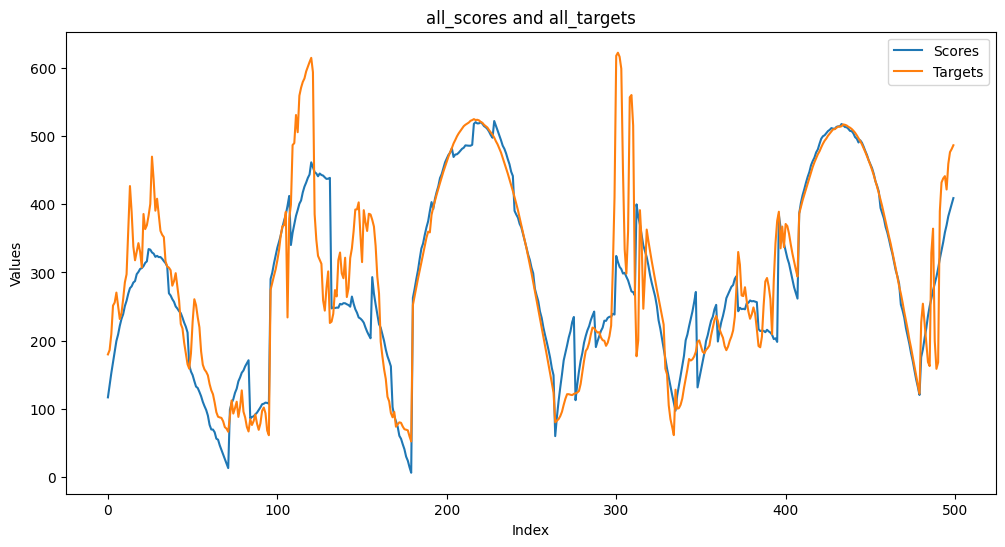

In [68]:
import matplotlib.pyplot as plt

# Vẽ all_scores và all_targets trên cùng một đồ thị
plt.figure(figsize=(12, 6))
plt.plot(all_scores[0:500], label='Scores')
plt.plot(all_targets[0:500], label='Targets')
plt.title('all_scores and all_targets')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

# Test 3 loai

In [69]:
X_test_1 = pd.read_csv("D://ĐATN//Data//File_da_xu_ly//full_data//Data_chia_theo_CI//data_lon_hon_50//Train_Val_Test_Type1//X_1_test.csv",header= 0)
X_test_2 = pd.read_csv("D://ĐATN//Data//File_da_xu_ly//full_data//Data_chia_theo_CI//data_lon_hon_50//Train_Val_Test_Type2//X_2_test.csv",header= 0)
X_test_3 = pd.read_csv("D://ĐATN//Data//File_da_xu_ly//full_data//Data_chia_theo_CI//data_lon_hon_50//Train_Val_Test_Type3//X_3_test.csv",header= 0)

Y_test_1 = pd.read_csv("D://ĐATN//Data//File_da_xu_ly//full_data//Data_chia_theo_CI//data_lon_hon_50//Train_Val_Test_Type1//Y_1_test.csv",header= 0)
Y_test_2 = pd.read_csv("D://ĐATN//Data//File_da_xu_ly//full_data//Data_chia_theo_CI//data_lon_hon_50//Train_Val_Test_Type2//Y_2_test.csv",header= 0)
Y_test_3 = pd.read_csv("D://ĐATN//Data//File_da_xu_ly//full_data//Data_chia_theo_CI//data_lon_hon_50//Train_Val_Test_Type3//Y_3_test.csv",header= 0)

In [70]:
X_test_1 = X_test_1.iloc[:, 1:45]
X_test_2 = X_test_2.iloc[:, 1:45]
X_test_3 = X_test_3.iloc[:, 1:45]
Y_test_1 = Y_test_1.iloc[:, 1:]
Y_test_2 = Y_test_2.iloc[:, 1:]
Y_test_3 = Y_test_3.iloc[:, 1:]


In [71]:
X_test_1_scaled = pd.DataFrame(X_scaler.transform(X_test_1.iloc[:, 0:8]), columns=X_test_1.iloc[:, 0:8].columns)
X_test_1_scaled = pd.concat([X_test_1_scaled, X_test_1.iloc[:, 8:]], axis=1)
X_test_2_scaled = pd.DataFrame(X_scaler.transform(X_test_2.iloc[:, 0:8]), columns=X_test_2.iloc[:, 0:8].columns)
X_test_2_scaled = pd.concat([X_test_2_scaled, X_test_2.iloc[:, 8:]], axis=1)
X_test_3_scaled = pd.DataFrame(X_scaler.transform(X_test_3.iloc[:, 0:8]), columns=X_test_3.iloc[:, 0:8].columns)
X_test_3_scaled = pd.concat([X_test_3_scaled, X_test_3.iloc[:, 8:]], axis=1)

In [72]:
Y_test_1_scaled = pd.DataFrame(Y_scaler.transform(Y_test_1), columns=Y_test_1.columns)
Y_test_2_scaled = pd.DataFrame(Y_scaler.transform(Y_test_2), columns=Y_test_2.columns)
Y_test_3_scaled = pd.DataFrame(Y_scaler.transform(Y_test_3), columns=Y_test_3.columns)


In [73]:
X_test_1_scaled = X_test_1_scaled.values
Y_test_1_scaled = Y_test_1_scaled.values

X_test_2_scaled = X_test_2_scaled.values
Y_test_2_scaled = Y_test_2_scaled.values

X_test_3_scaled = X_test_3_scaled.values
Y_test_3_scaled = Y_test_3_scaled.values

In [74]:
test_data_1 = Irradiance_Data(X_test_1_scaled,Y_test_1_scaled)
test_data_loader_1 = get_loader(test_data_1)

test_data_2 = Irradiance_Data(X_test_2_scaled,Y_test_2_scaled)
test_data_loader_2 = get_loader(test_data_2)

test_data_3 = Irradiance_Data(X_test_3_scaled,Y_test_3_scaled)
test_data_loader_3 = get_loader(test_data_3)


# Test loại 1

In [75]:
model = torch.load("D://ĐATN//Data//File_da_xu_ly//full_data//Data_chia_theo_CI//data_lon_hon_50//Model_SGD_0.01_256//model_predict_cnn_lstm.pth.tar").to(device)

model.eval()
with torch.no_grad():
    flag = 0
    # mae_test = 0
    total_scores_test = None
    total_target_test = None
    for data_test,target_test in tqdm(test_data_loader_1):
        # print(target_test)
        data_test = data_test.to(device=device,dtype=torch.float32)
        target_test = target_test.to(device=device,dtype=torch.float32).squeeze(2)

        score_test = model(data_test)

        target_test_unstd = Y_scaler.inverse_transform(target_test.cpu())
        score_test_unstd = Y_scaler.inverse_transform(score_test.cpu())

        if flag == 0:
            flag = 1
            all_scores = score_test_unstd
            all_targets =  target_test_unstd
        else:
            all_scores = np.concatenate((all_scores,score_test_unstd),axis=0)
            all_targets = np.concatenate((all_targets,target_test_unstd),axis=0)


all_targets_1 = all_targets.flatten()
all_scores_1 = all_scores.flatten()

mask_all_targets = (all_targets_1 > 0).astype(float)

# print(all_targets.shape)
# print(all_scores.shape)
            
def mse_calculation(output, target, mask):
    mse = np.sum(((output - target) * mask) ** 2.0) / np.sum(mask)
    return mse
def mae_calculation(output, target, mask):
    mae = np.sum(np.abs((output - target) * mask)) / np.sum(mask)
    return mae

mse = mse_calculation(all_scores_1,all_targets_1,mask_all_targets)
mae = mae_calculation(all_scores_1,all_targets_1,mask_all_targets)

print("Test loại 1")
print(mae)
print(math.sqrt(mse))


  0%|          | 0/119 [00:00<?, ?it/s]

100%|██████████| 119/119 [00:01<00:00, 72.18it/s]

Test loại 1
65.72170403388387
118.93823880433555


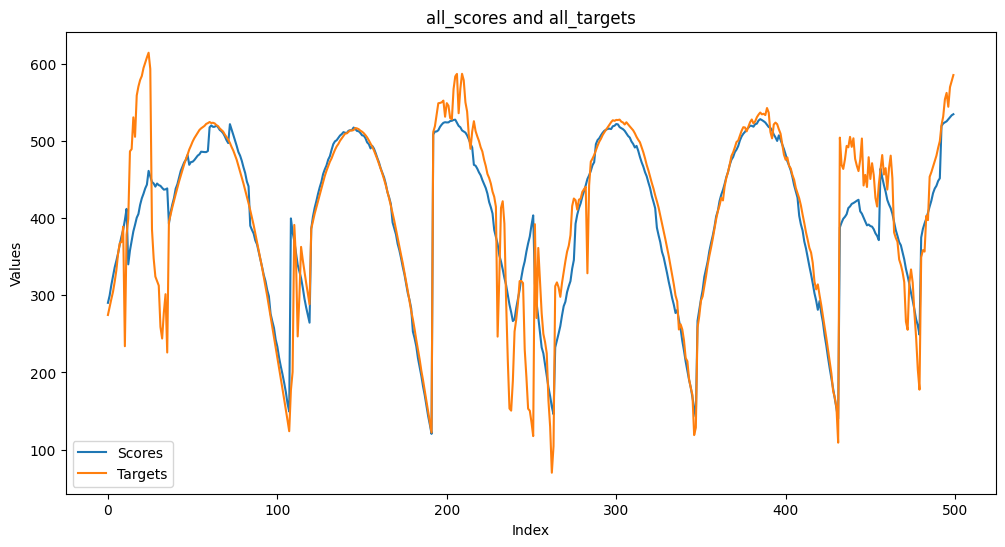

In [76]:
import matplotlib.pyplot as plt

# Vẽ all_scores và all_targets trên cùng một đồ thị
plt.figure(figsize=(12, 6))
plt.plot(all_scores_1[0:500], label='Scores')
plt.plot(all_targets_1[0:500], label='Targets')
plt.title('all_scores and all_targets')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

# Test loại 2

In [77]:
model = torch.load("D://ĐATN//Data//File_da_xu_ly//full_data//Data_chia_theo_CI//data_lon_hon_50//Model_SGD_0.01_256//model_predict_cnn_lstm.pth.tar").to(device)

model.eval()
with torch.no_grad():
    flag = 0
    # mae_test = 0
    total_scores_test = None
    total_target_test = None
    for data_test,target_test in tqdm(test_data_loader_2):
        # print(target_test)
        data_test = data_test.to(device=device,dtype=torch.float32)
        target_test = target_test.to(device=device,dtype=torch.float32).squeeze(2)

        score_test = model(data_test)

        target_test_unstd = Y_scaler.inverse_transform(target_test.cpu())
        score_test_unstd = Y_scaler.inverse_transform(score_test.cpu())

        if flag == 0:
            flag = 1
            all_scores = score_test_unstd
            all_targets =  target_test_unstd
        else:
            all_scores = np.concatenate((all_scores,score_test_unstd),axis=0)
            all_targets = np.concatenate((all_targets,target_test_unstd),axis=0)


all_targets_2 = all_targets.flatten()
all_scores_2 = all_scores.flatten()

mask_all_targets = (all_targets_2 > 0).astype(float)

# print(all_targets.shape)
# print(all_scores.shape)
            
def mse_calculation(output, target, mask):
    mse = np.sum(((output - target) * mask) ** 2.0) / np.sum(mask)
    return mse
def mae_calculation(output, target, mask):
    mae = np.sum(np.abs((output - target) * mask)) / np.sum(mask)
    return mae

mse = mse_calculation(all_scores_2,all_targets_2,mask_all_targets)
mae = mae_calculation(all_scores_2,all_targets_2,mask_all_targets)

print("Test loại 2")
print(mae)
print(math.sqrt(mse))


100%|██████████| 33/33 [00:00<00:00, 54.42it/s]

Test loại 2
103.85917059782923
150.10816552577595


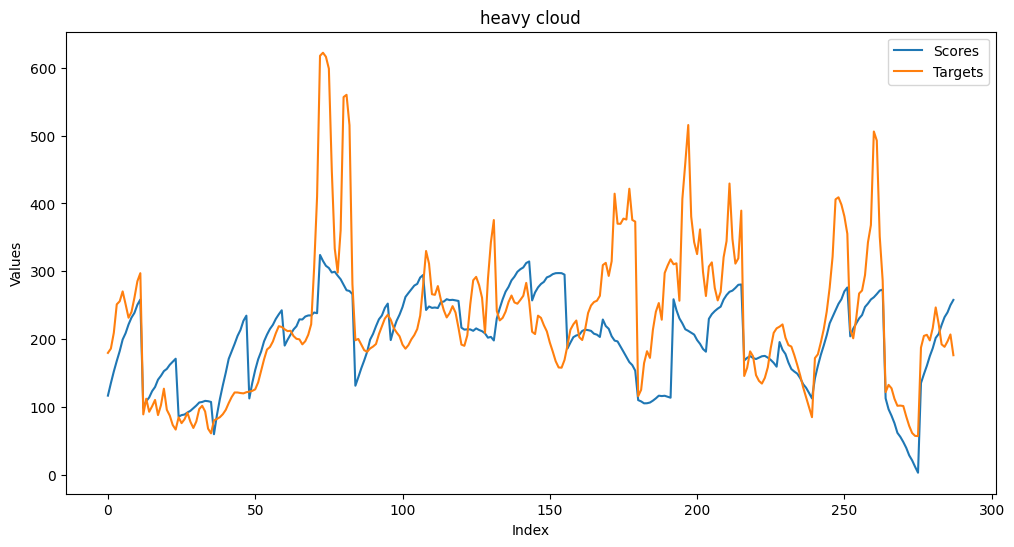

In [78]:
import matplotlib.pyplot as plt

# Vẽ all_scores và all_targets trên cùng một đồ thị
plt.figure(figsize=(12, 6))
plt.plot(all_scores_2[0:288], label='Scores')
plt.plot(all_targets_2[0:288], label='Targets')
plt.title('heavy cloud')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

# Test loại 3

In [79]:
model = torch.load("D://ĐATN//Data//File_da_xu_ly//full_data//Data_chia_theo_CI//data_lon_hon_50//Model_SGD_0.01_256//model_predict_cnn_lstm.pth.tar").to(device)

model.eval()
with torch.no_grad():
    flag = 0
    # mae_test = 0
    total_scores_test = None
    total_target_test = None
    for data_test,target_test in tqdm(test_data_loader_3):
        # print(target_test)
        data_test = data_test.to(device=device,dtype=torch.float32)
        target_test = target_test.to(device=device,dtype=torch.float32).squeeze(2)

        score_test = model(data_test)

        target_test_unstd = Y_scaler.inverse_transform(target_test.cpu())
        score_test_unstd = Y_scaler.inverse_transform(score_test.cpu())

        if flag == 0:
            flag = 1
            all_scores = score_test_unstd
            all_targets =  target_test_unstd
        else:
            all_scores = np.concatenate((all_scores,score_test_unstd),axis=0)
            all_targets = np.concatenate((all_targets,target_test_unstd),axis=0)


all_targets_3 = all_targets.flatten()
all_scores_3 = all_scores.flatten()

mask_all_targets = (all_targets_3 > 0).astype(float)

# print(all_targets.shape)
# print(all_scores.shape)
            
def mse_calculation(output, target, mask):
    mse = np.sum(((output - target) * mask) ** 2.0) / np.sum(mask)
    return mse
def mae_calculation(output, target, mask):
    mae = np.sum(np.abs((output - target) * mask)) / np.sum(mask)
    return mae

mse = mse_calculation(all_scores_3,all_targets_3,mask_all_targets)
mae = mae_calculation(all_scores_3,all_targets_3,mask_all_targets)

print("Test loại 3")
print(mae)
print(math.sqrt(mse))


100%|██████████| 40/40 [00:00<00:00, 60.31it/s]

Test loại 3
115.08543463417416
161.6350644020771


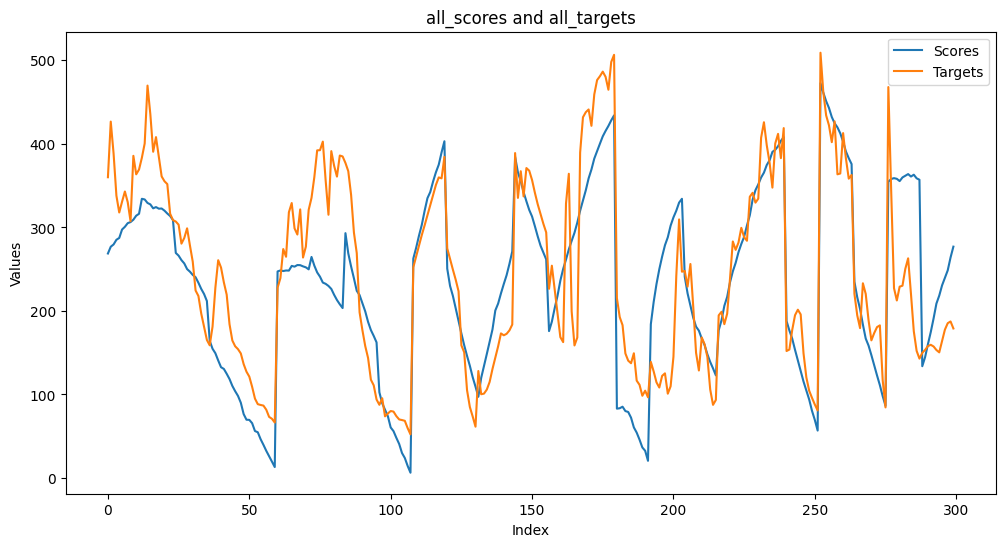

In [80]:
import matplotlib.pyplot as plt

# Vẽ all_scores và all_targets trên cùng một đồ thị
plt.figure(figsize=(12, 6))
plt.plot(all_scores_3[0:300], label='Scores')
plt.plot(all_targets_3[0:300], label='Targets')
plt.title('all_scores and all_targets')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()